# Hands-On Support Vector Machines
***

In this notebook we'll explore the details of the Soft-Margin SVM and look at how the choice of tuning parameters  affects the learned models.  We'll also look at kernel SVMs for non-linearly separable and methods for choosing and visualizing good hyperparameters.   

**Note**: There are some helper functions at the bottom of this notebook.  Scroll down and execute those cells before continuing. 

In [1]:
import numpy as np

### Part 1: Soft-Margin SVM Details
***

Suppose you have the following labeled data set (assume here that red corresponds to $y=1$ and blue corresponds to $y = -1$) and suppose the SVM decision boundary is defined by the weights ${\bf w} = [-1/4, ~ 1/4]^T$ and $b = -1/4$. 


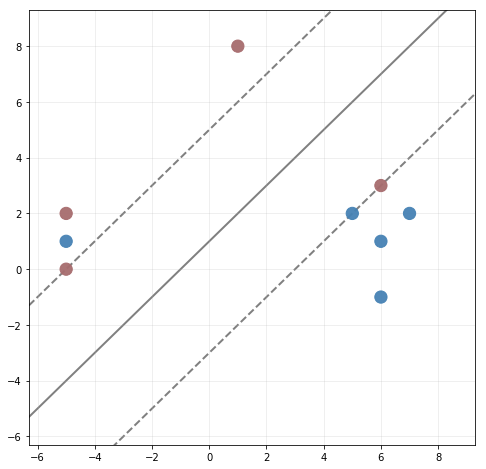

In [3]:
# Data and Labels 
X = np.array([[1,8],[7,2],[6,-1],[-5,0], [-5,1], [-5,2],[6,3],[6,1],[5,2]])
y = np.array([1,-1,-1,1,-1,1,1,-1,-1])

# Support vector parameters 
w, b = np.array([-1/4, 1/4]), -1/4
# w, b = np.array([-1/2, 1/2]), -1/2

# Plot the data and support vector boundaries 
linear_plot(X, y, w=w, b=b)

**Part A**: What is the margin of this particular SVM? 

In [5]:
1 / np.linalg.norm(w)

2.82842712474619

**Part B**: Which training examples are the support vectors? 

In [7]:
for x_, y_ in zip(X, y):
    if np.abs(w.dot(x_) + b) <= 1:
        print(x_)

[-5  0]
[6 3]
[5 2]


**Part C**: Which training examples have nonzero slack? 

In [8]:
for x_, y_ in zip(X, y):
    if np.abs(w.dot(x_) + b) <= 1:
        print(x_)

[-5  0]
[6 3]
[5 2]


**Part D**: Compute the slack $\xi_i$ associated with the misclassified points. Do these values jive with the plot of the data and the support vector boundaries? 

In [9]:
for x_, y_ in zip(X, y):
    pred = y_*(w.dot(x_) + b)
    if pred < 1:
        print(x_)
        print(1 - pred)

[-5  1]
2.25
[6 3]
2.0


In [10]:
X

array([[ 1,  8],
       [ 7,  2],
       [ 6, -1],
       [-5,  0],
       [-5,  1],
       [-5,  2],
       [ 6,  3],
       [ 6,  1],
       [ 5,  2]])

In [11]:
y

array([ 1, -1, -1,  1, -1,  1,  1, -1, -1])

In [12]:
b

-0.25

In [13]:
w

array([-0.25,  0.25])

In [14]:
c = 3

In [15]:
alpha = np.array([c/2,
c,
0,
0,
c,
0,
0,
c/2,
0])

In [16]:
np.sum(alpha * y)

-6.0

**Part E**: Suppose we obtained the parameters ${\bf w}$ and $b$ by solving the Dual optimization problem.  Which of the following are possible realizations of the Lagrange multipliers? Here $C$ is the hyperparameter associated with the slack penalty term in the primal objective function. 

$
\texttt{i}) ~~~~\quad \alpha^T = \left[ \begin{array}{r} 1.0 & 1.5 & 0.5 & 0.75 & 0.25 & 2.0 & 1.5 & 0.25 & 0.5 \end{array} \right] 
$

$
\texttt{ii})~~ \quad \alpha^T = \left[ \begin{array}{r} C/2 & C & 0 & 0 & C & 0 & 0 & C/2& 0 \end{array} \right]
$

$
\texttt{iii}) \quad \alpha^T = \left[ \begin{array}{r} C/3 & C & 0 & 0 & C & 0 & 0 & C/2 & 0 \end{array} \right]
$

### Part 2: The Margin vs Slack 
***

In this problem we'll figure out how to fit linear SVM models to data using sklearn.  Consider the data shown below. 


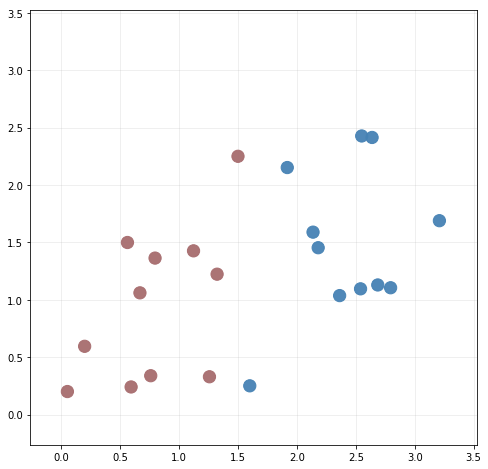

In [17]:
X, y = part2data()
linear_plot(X, y)

**Part A**: Let's fit a linear Soft-Margin SVM to the data above. For SVMs with a linear kernel we'll use the [`LinearSVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) method from sklearn's `svm` module.  Go now and look at the documentation. 

Recall that the primal objective function for the linear kernel SVM is as follows 


$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i^p
$$

The two optional parameters in `LinearSVC` that we'll be most concerned with are `C`, the hyperparameter weighting the slackness contribution to the primal objective function, and `loss`, which determines the exponent on the slack variables in the sum. 

Write some code below to train a linear SVM with $C=1$ and $p=1$, get the computed weight vector and bias, and the plot the resulting model. 

In [21]:
w

array([[-1.22506753,  0.27744058]])

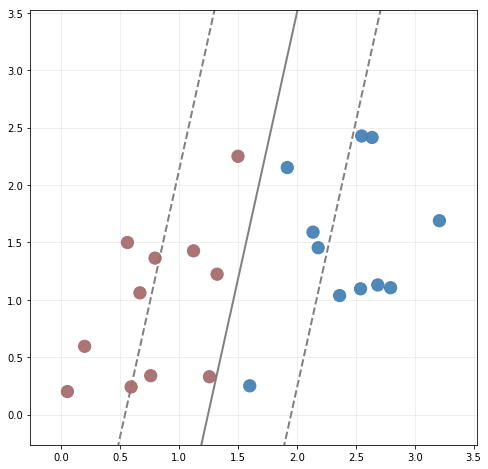

In [23]:
from sklearn.svm import LinearSVC

# TODO: Train the model and get the parameters, pay attention to the loss parameter
svm = LinearSVC(C = 1, loss='hinge')
svm.fit(X, y)
w = svm.coef_[0]
b = svm.intercept_

linear_plot(X, y, w=w, b=b)

**Part B**: Experiment with different values of `C`.  How does the choice of `C` affect the nature of the decision boundary and the associated margin? 

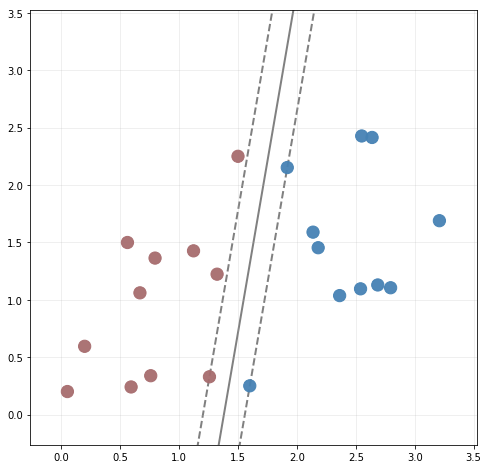

In [30]:
svm = LinearSVC(C = 100, loss='hinge')
svm.fit(X, y)
w = svm.coef_[0]
b = svm.intercept_

linear_plot(X, y, w=w, b=b)

**Part C**: In general, how does the choice of `C` affect the bias and variance of the model? 

As `C` increases, it acts as a regularizer, and increases the bias while decreasing variance

### Part 3: Nonlinear SVM, Parameter Tuning, Accuracy, and Cross-Validation 
***

Any support vector machine classifier will have at least one parameter that needs to be tuned based on the training data.  The guaranteed parameter is the $C$ associated with the slack variables in the primal objective function, i.e. 

$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i
$$

If you use a kernel fancier than the linear kernel then you will likely have other parameters as well. For instance in the polynomial kernel $K({\bf x}, {\bf z}) = ({\bf x}^T{\bf z} + c)^d$ you have to select the shift $c$ and the polynomial degree $d$.  Similarly the rbf kernel

$$
K({\bf x}, {\bf z}) = \exp\left[-\gamma\|{\bf x} - {\bf z}\|^2\right]
$$

has one tuning parameter, namely $\gamma$, which controls how fast the similarity measure drops off with distance between ${\bf x}$ and ${\bf z}$. 

For our examples we'll consider the rbf kernel, which gives us two parameters to tune, namely $C$ and $\gamma$. 

Consider the following two dimensional data

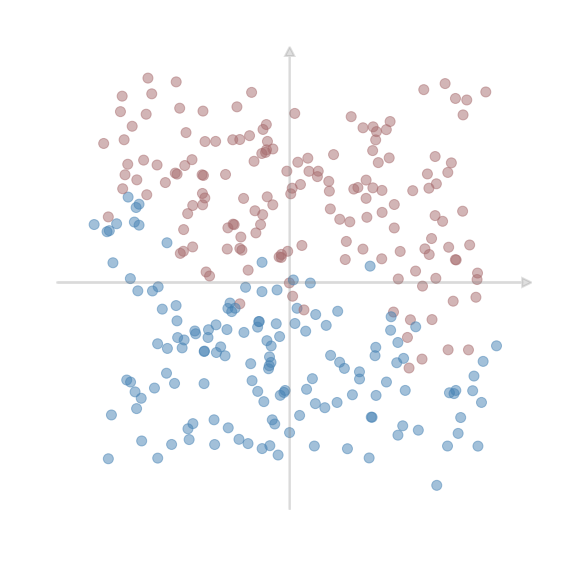

In [31]:
X, y = part3data(N=300, seed=1235)
nonlinear_plot(X, y)

**Part A**: We can use the method [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from sklearn's `svm` module to fit an SVM with a nonlinear kernel to the data.  Go now and look at the documentation. Note that we pass the `kernel="rbr"` parameter to use the RBF kernel.  The other two parameters we'll be concerned with are `C` and the RBF parameter `gamma`.   

Write some code to fit an SVM with RBF kernel to the data and plot the results.  Use the parameter values `C=1` and `gamma=1`. 

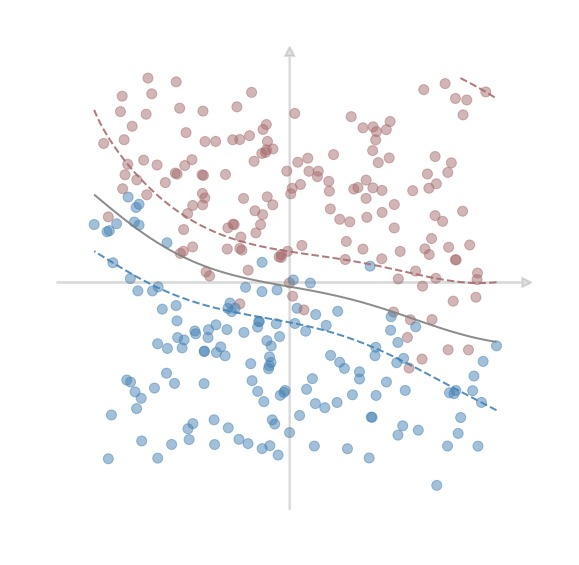

In [37]:
from sklearn.svm import SVC

nlsvm = SVC(C=1, kernel='rbf', gamma=1)
nlsvm.fit(X, y)
nonlinear_plot(X, y, nlsvm)

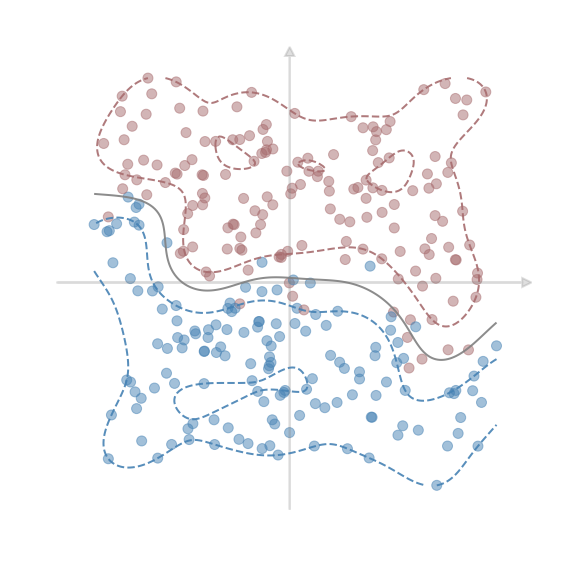

In [38]:
nlsvm = SVC(C=1, kernel='rbf', gamma=10)
nlsvm.fit(X, y)
nonlinear_plot(X, y, nlsvm)

**Part B**: In this part we'll use cross-validation to estimate the validation accuracy achieved by our model.  Experiment with the values of the hyperparameters to see if you can get a good validation accuracy. How do the choice of `C` and `gamma` affect the resulting decision boundary? 


cross-val mean-accuracy: 0.940


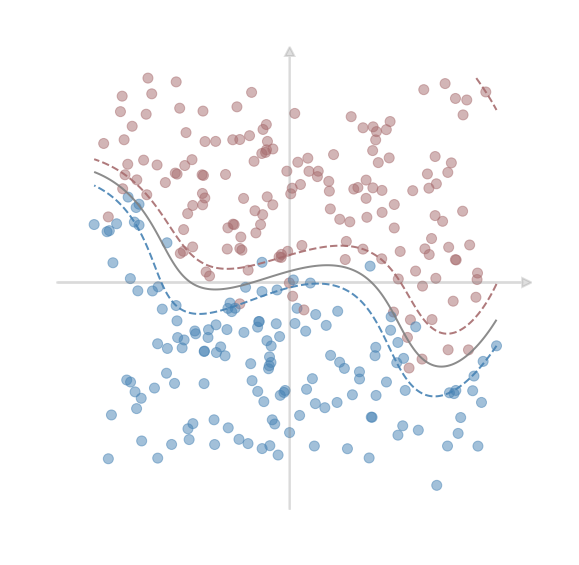

In [45]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# TODO: use cross_val_score to estmiate the cross validation accuracy
nlsvm = SVC(C=100, gamma=1)
scores = cross_val_score(nlsvm, X, y)
print("cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))

nonlinear_plot(X, y, nlsvm)

**Part C**: How does the choice of **kernel** function affect the bias/variance of the model?  


### Part 4: Automating the Parameter Search 
***

On the previous problem we were able to choose some OK parameters just by hand-tuning.  But in real life (where time is money) it would be better to do something a little more automated.  One common thing to do is a **grid-search** over a predefined range of the parameters.  In this case you will loop over all possible combinations of parameters, estimate the accuracy of your model using K-Folds cross-validation, and then choose the parameter combination that produces the highest validation accuracy. 

**Part A**: Below is an experiment where we search over a logarithmic range between $2^{-5}$ and $2^{5}$ for $C$ and a range between $2^{-5}$ and $2^{5}$ for $\gamma$.  For the accuracy measure we use K-Folds CV with $K=3$.

In [51]:
from sklearn.model_selection import cross_val_score, GridSearchCV

c_range = np.logspace(-5, 5, 11, base=2)
g_range = np.logspace(-5, 5, 11, base=2)
# TODO: use GridSearchCV to find the best parameter using cross validation
params = {
    'C' : c_range, 
    'gamma' : g_range
}

nlsvm = SVC()
grid = GridSearchCV(nlsvm, params)
grid.fit(X, y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([3.125e-02, 6.250e-02, 1.250e-01, 2.500e-01, 5.000e-01, 1.000e+00,
       2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01]),
                         'gamma': array([3.125e-02, 6.250e-02, 1.250e-01, 2.500e-01, 5.000e-01, 1.000e+00,
       2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01])})

**Part B**: The following function will plot a heat-map of the cross-validation accuracies for each combination of parameters.  Which combination looks the best?

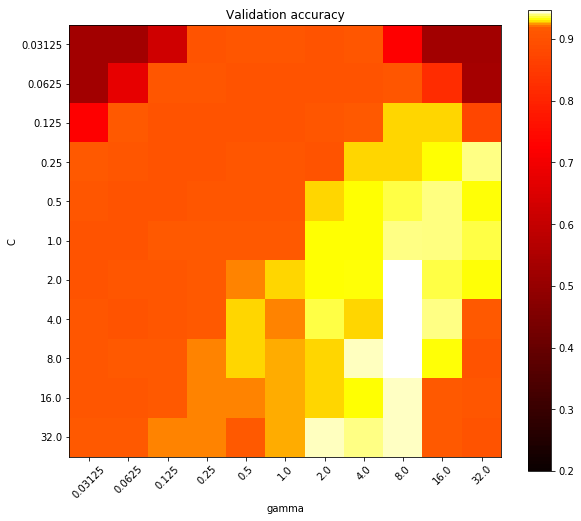

In [53]:
plotSearchGrid(grid)

**Part C**: The GridSearchCV object scores, among other things, the best combination of parameters as well as the cross-validation accuracy achieved with those parameters.  Print those quantities for our model. 

In [63]:
print("Best score: ",grid.best_score_)
print("Best params: ",grid.best_params_)

Best score:  0.9466666666666667
Best params:  {'C': 2.0, 'gamma': 8.0}


**Part D**: The GridSearchCV object also stores the classifier trained with the best hyperparameters.  Pass this best estimator into the `nonlinear_plot` function to view the best decision boundary. 

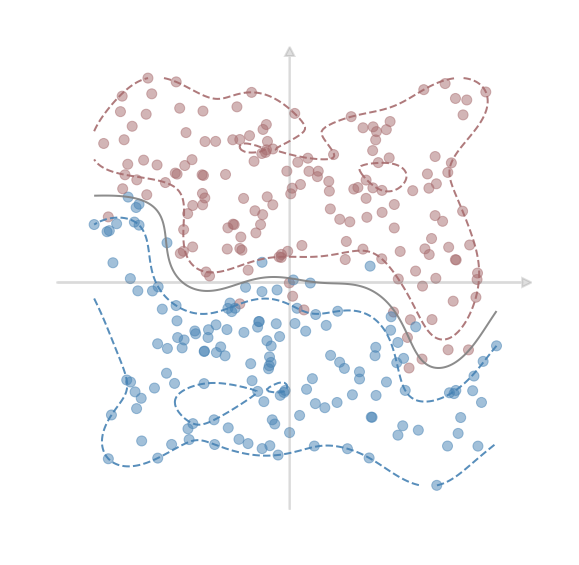

In [61]:
best_svm = grid.best_estimator_
nonlinear_plot(X, y, best_svm)

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

### Helper Functions
***

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
%matplotlib inline

def linear_plot(X, y, w=None, b=None):
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    
    # Plot data 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.scatter(X[:,0], X[:,1], color=colors, s=150, alpha=0.95, zorder=2)
    
    # Plot boundaries 
    lower_left = np.min([np.min(X[:,0]), np.min(X[:,1])])
    upper_right = np.max([np.max(X[:,0]), np.max(X[:,1])])
    gap = .1*(upper_right-lower_left)
    xplot = np.linspace(lower_left-gap, upper_right+gap, 20)
    if w is not None and b is not None: 
        ax.plot(xplot, (-b - w[0]*xplot)/w[1], color="gray", lw=2, zorder=1)
        ax.plot(xplot, ( 1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        ax.plot(xplot, (-1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        
    
    ax.set_xlim([lower_left-gap, upper_right+gap])
    ax.set_ylim([lower_left-gap, upper_right+gap])
    
    ax.grid(alpha=0.25)
    
def part2data():
    
    np.random.seed(1239)
    
    X = np.zeros((22,2))
    X[0:10,0]  = 1.5*np.random.rand(10) 
    X[0:10,1]  = 1.5*np.random.rand(10)
    X[10:20,0] = 1.5*np.random.rand(10) +  1.75
    X[10:20,1] = 1.5*np.random.rand(10) +  1
    X[20,0] = 1.5
    X[20,1] = 2.25
    X[21,0] = 1.6
    X[21,1] = 0.25
    
    y = np.ones(22)
    y[10:20] = -1 
    y[20] = 1
    y[21] = -1
    
    return X, y

def part3data(N=100, seed=1235):
    
    np.random.seed(seed)
    
    X = np.random.uniform(-1,1,(N,2))
    y = np.array([1 if y-x > 0 else -1 for (x,y) in zip(X[:,0]**2 * np.sin(2*np.pi*X[:,0]), X[:,1])])
    X = X + np.random.normal(0,.1,(N,2))
    
    return X, y

def nonlinear_plot(X, y, clf=None): 
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    ax.scatter(X[:,0],X[:,1], marker='o', color=colors, s=100, alpha=0.5)
    
    ax.arrow(-1.25,0,2.5,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    ax.arrow(0,-1.25,0,2.5, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    z = np.linspace(0.25,3.5,10)
    
    ax.set_xlim([-1.50,1.50])
    ax.set_ylim([-1.50,1.50])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16)
    

    if clf: 
        
        clf.fit(X,y)

        x_min = X[:, 0].min()+.00
        x_max = X[:, 0].max()-.00
        y_min = X[:, 1].min()+.00
        y_max = X[:, 1].max()-.00

        colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.contour(XX, YY, Z, colors=[mycolors["blue"], "gray", mycolors["red"]], linestyles=['--', '-', '--'],
                    levels=[-1.0, 0, 1.0], linewidths=[2,2,2], alpha=0.9)
    

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")